In [1]:
import os
import math
import random
import argparse
from collections import Counter, defaultdict
from itertools import chain, combinations
import ast
import copy
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
import os
import random
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
from utils.Spambase.split_data import split_data_equal
from utils.aggregate_functions import aggregate_lr_models
from utils.evaluate_coalitions_new import evaluate_coalitions2
from utils.nash1 import find_nash_equilibria_v2
from utils.shapley_value import compute_and_visualize_shapley_values

In [3]:
# disable ConvergenceWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
# File patterns.
train_files_pattern = "..."
test_files_pattern = "..."

# Concatenate all training files.
df_train_global = pd.concat([
    pd.read_csv(train_files_pattern.format(i=i)) for i in range(1, 19)
]).dropna()

# Concatenate all testing files.
df_test_global = pd.concat([
    pd.read_csv(test_files_pattern.format(i=i)) for i in range(1, 19)
]).dropna()

# Split features and labels.
X_train_global = df_train_global.drop('act', axis=1)
y_train_global = df_train_global['act']

X_test_global = df_test_global.drop('act', axis=1)
y_test_global = df_test_global['act']

# Encode labels.
label_encoder = LabelEncoder()
y_train_global = label_encoder.fit_transform(y_train_global)
y_test_global = label_encoder.transform(y_test_global)

# Scale features.
scaler_global = StandardScaler()
X_train_global_scaled = scaler_global.fit_transform(X_train_global)
X_test_global_scaled  = scaler_global.transform(X_test_global)
# Create a stratified subsample of the test set to speed up the runtime.
subsample_size = 1500
X_test_global_scaled, _, y_test_global, _ = train_test_split(
    X_test_global_scaled, y_test_global,
    train_size=subsample_size,
    random_state=42,
    stratify=y_test_global
)
print("Subsampled test set shape:", X_test_global_scaled.shape)

Subsampled test set shape: (1500, 38)


In [ ]:
n_trials = 50
base_random_seed = 42
max_iters = [10, 100]
approach = 'fedlr'

save_dir = "..."
os.makedirs(save_dir, exist_ok=True)


train_csv_path = ".../metadata/new_runs/train.csv"
df_full_train = pd.read_csv(train_csv_path).dropna(subset=['act']).reset_index(drop=True)


# Loop over different client counts 
for n_clients in range(90, 101, 5):
    print(f"Running experiments for n_clients = {n_clients}")
    all_details_for_client = []  


    for max_iter in max_iters:
        nash_counts = Counter()
        details_for_this_param = []
        client_accuracy_details = []


        for trial in range(n_trials):

            rand_component = random.randint(0, 500)
            trial_seed = base_random_seed + trial + int(1000 * max_iter) + 2 * rand_component

            # First, sample a stratified subset of 10000 rows from the full training data.
            df_trial, _ = train_test_split(
                df_full_train,
                train_size=10000,
                random_state=trial_seed,
                stratify=df_full_train['act']
            )
            # Use this sample, for partitioning among clients.
            df_remaining = df_trial.copy()


            client_partitions = []

            sample_size = 3500 // n_clients
            for client_idx in range(n_clients):
                if len(df_remaining) < sample_size:
                    raise ValueError("err")

                if len(df_remaining) == sample_size:
                    df_client = df_remaining.copy()
                    df_remaining = df_remaining.iloc[0:0] 




                else:
                    df_client, df_remaining = train_test_split(
                        df_remaining,
                        train_size=sample_size,
                        random_state=trial_seed,
                        stratify=df_remaining['act']
                    )
                df_client = df_client.reset_index(drop=True)
                client_partitions.append(df_client)

            client_models = []
            client_global_accuracies = {}

            for client_idx, df_client in enumerate(client_partitions):

                X_client = df_client.drop(columns=['act'])
                y_client = df_client['act']


                client_scaler = StandardScaler()
                X_client_scaled = client_scaler.fit_transform(X_client)


                y_client_encoded = label_encoder.transform(y_client)


                model = LogisticRegression(random_state=trial_seed, max_iter=max_iter)
                model.fit(X_client_scaled, y_client_encoded)
                client_models.append(model)


                y_pred_global = model.predict(X_test_global_scaled)
                acc_global = accuracy_score(y_test_global, y_pred_global)
                client_global_accuracies[client_idx] = acc_global


            df_results = evaluate_coalitions2(
                client_models=client_models,
                client_global_accuracies=client_global_accuracies,
                n_clients=n_clients,
                aggregator_func=aggregate_lr_models,
                X_test=X_test_global_scaled,
                y_test=y_test_global,
                corrupt_client_indices=[],
                approach=approach
            )
            df_results['Trial'] = trial + 1
            df_results['Max Iter or Depth'] = max_iter


            df_nash = find_nash_equilibria_v2(df_results.reset_index())
            if not df_nash.empty and 'Combination' in df_nash.columns:
                for coalition in df_nash['Combination']:
                    nash_counts[coalition] += 1

            df_nash['Trial'] = trial + 1
            df_nash['Max Iter or Depth'] = max_iter
            details_for_this_param.append(df_nash)

    
            trial_acc = {
                'Trial': trial + 1,
                'Max Iter or Depth': max_iter,
            }
            for j in range(n_clients):
                trial_acc[f'Client {j+1} Accuracy'] = client_global_accuracies.get(j, np.nan)
            client_accuracy_details.append(trial_acc)


        df_details = pd.concat(details_for_this_param, ignore_index=True)
        df_client_accuracy = pd.DataFrame(client_accuracy_details)
        df_combined = df_details.merge(
            df_client_accuracy,
            on=['Trial', 'Max Iter or Depth'],
            how='left'
        )

        df_combined['n_clients'] = n_clients
        all_details_for_client.append(df_combined)


    final_details_df = pd.concat(all_details_for_client, ignore_index=True)
    details_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}_nclients_{n_clients}.csv")
    final_details_df.to_csv(details_path, index=False)


In [5]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

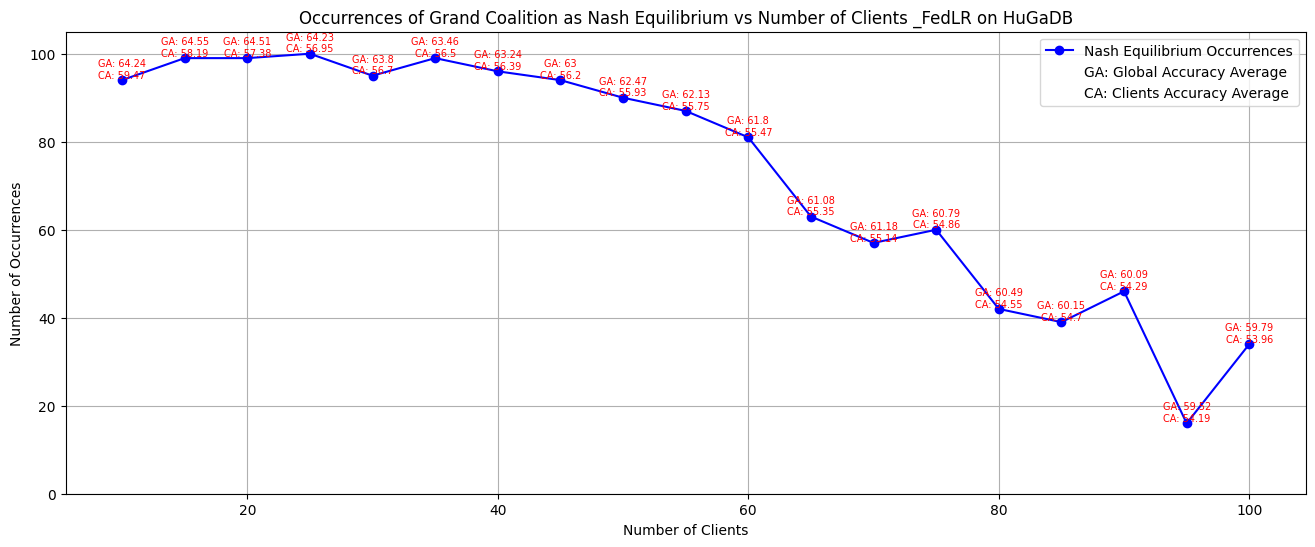

In [ ]:
save_dir = "..."
approach = 'fedlr'
client_range = range(10, 101, 5)


occurrence_counts = []
global_acc_avgs = []
clients_acc_avgs = []

for n_clients in client_range:
    file_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}_nclients_{n_clients}.csv")
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        count = len(df)
        occurrence_counts.append(count)
        

        if 'Global Accuracy' in df.columns:
            global_avg = df['Global Accuracy'].mean()
        else:
            global_avg = np.nan
        global_acc_avgs.append(global_avg)
        

        client_cols = [col for col in df.columns if col.startswith("Client") and "Accuracy" in col]
        if client_cols:
            clients_avg = df[client_cols].mean().mean()
        else:
            clients_avg = np.nan
        clients_acc_avgs.append(clients_avg)
    else:

        occurrence_counts.append(0)
        global_acc_avgs.append(np.nan)
        clients_acc_avgs.append(np.nan)
        print(f"File not found: {file_path}")

plt.figure(figsize=(16, 6))
plt.yticks(np.arange(0, 101, 20))
plt.ylim(0, 105)
line, = plt.plot(list(client_range), occurrence_counts, marker='o', linestyle='-',color= 'blue', label='Nash Equilibrium Occurrences')
plt.title("Occurrences of Grand Coalition as Nash Equilibrium vs Number of Clients _FedLR on HuGaDB")
plt.xlabel("Number of Clients")
plt.ylabel("Number of Occurrences")
plt.grid(True)

for x, occ, g_avg, c_avg in zip(client_range, occurrence_counts, global_acc_avgs, clients_acc_avgs):
    annotation_text = f"GA: {100*g_avg:.4g}\nCA: {100*c_avg:.4g}"
    plt.text(x, occ, annotation_text, color='red', fontsize=7, ha='center', va='bottom')


ga_legend = Line2D([], [], color='red', marker='None', linestyle='None', label='GA: Global Accuracy Average')
ca_legend = Line2D([], [], color='red', marker='None', linestyle='None', label='CA: Clients Accuracy Average')


plt.legend(handles=[line, ga_legend, ca_legend])
plt.show()


### With more sample : sample_size = 7000 // n_clients and test size is : Subsampled test set shape: (1500, 38)

In [ ]:
n_trials = 50
base_random_seed = 42
max_iters = [10, 100]
approach = 'fedlr'

save_dir = "..."
os.makedirs(save_dir, exist_ok=True)


train_csv_path = ".../metadata/new_runs/train.csv"
df_full_train = pd.read_csv(train_csv_path).dropna(subset=['act']).reset_index(drop=True)


# Loop over different client counts 
for n_clients in range(10, 101, 5):
    print(f"Running experiments for n_clients = {n_clients}")
    all_details_for_client = []  


    for max_iter in max_iters:
        nash_counts = Counter()
        details_for_this_param = []
        client_accuracy_details = []


        for trial in range(n_trials):

            rand_component = random.randint(0, 500)
            trial_seed = base_random_seed + trial + int(1000 * max_iter) + 2 * rand_component

            # First, sample a stratified subset of 10000 rows from the full training data.
            df_trial, _ = train_test_split(
                df_full_train,
                train_size=10000,
                random_state=trial_seed,
                stratify=df_full_train['act']
            )
            # Use this sample, for partitioning among clients.
            df_remaining = df_trial.copy()


            client_partitions = []

            sample_size = 7000 // n_clients
            for client_idx in range(n_clients):
                if len(df_remaining) < sample_size:
                    raise ValueError("err")

                if len(df_remaining) == sample_size:
                    df_client = df_remaining.copy()
                    df_remaining = df_remaining.iloc[0:0] 




                else:
                    df_client, df_remaining = train_test_split(
                        df_remaining,
                        train_size=sample_size,
                        random_state=trial_seed,
                        stratify=df_remaining['act']
                    )
                df_client = df_client.reset_index(drop=True)
                client_partitions.append(df_client)

            client_models = []
            client_global_accuracies = {}

            for client_idx, df_client in enumerate(client_partitions):

                X_client = df_client.drop(columns=['act'])
                y_client = df_client['act']


                client_scaler = StandardScaler()
                X_client_scaled = client_scaler.fit_transform(X_client)


                y_client_encoded = label_encoder.transform(y_client)


                model = LogisticRegression(random_state=trial_seed, max_iter=max_iter)
                model.fit(X_client_scaled, y_client_encoded)
                client_models.append(model)


                y_pred_global = model.predict(X_test_global_scaled)
                acc_global = accuracy_score(y_test_global, y_pred_global)
                client_global_accuracies[client_idx] = acc_global


            df_results = evaluate_coalitions2(
                client_models=client_models,
                client_global_accuracies=client_global_accuracies,
                n_clients=n_clients,
                aggregator_func=aggregate_lr_models,
                X_test=X_test_global_scaled,
                y_test=y_test_global,
                corrupt_client_indices=[],
                approach=approach
            )
            df_results['Trial'] = trial + 1
            df_results['Max Iter or Depth'] = max_iter


            df_nash = find_nash_equilibria_v2(df_results.reset_index())
            if not df_nash.empty and 'Combination' in df_nash.columns:
                for coalition in df_nash['Combination']:
                    nash_counts[coalition] += 1

            df_nash['Trial'] = trial + 1
            df_nash['Max Iter or Depth'] = max_iter
            details_for_this_param.append(df_nash)

    
            trial_acc = {
                'Trial': trial + 1,
                'Max Iter or Depth': max_iter,
            }
            for j in range(n_clients):
                trial_acc[f'Client {j+1} Accuracy'] = client_global_accuracies.get(j, np.nan)
            client_accuracy_details.append(trial_acc)


        df_details = pd.concat(details_for_this_param, ignore_index=True)
        df_client_accuracy = pd.DataFrame(client_accuracy_details)
        df_combined = df_details.merge(
            df_client_accuracy,
            on=['Trial', 'Max Iter or Depth'],
            how='left'
        )

        df_combined['n_clients'] = n_clients
        all_details_for_client.append(df_combined)


    final_details_df = pd.concat(all_details_for_client, ignore_index=True)
    details_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}_nclients_{n_clients}.csv")
    final_details_df.to_csv(details_path, index=False)


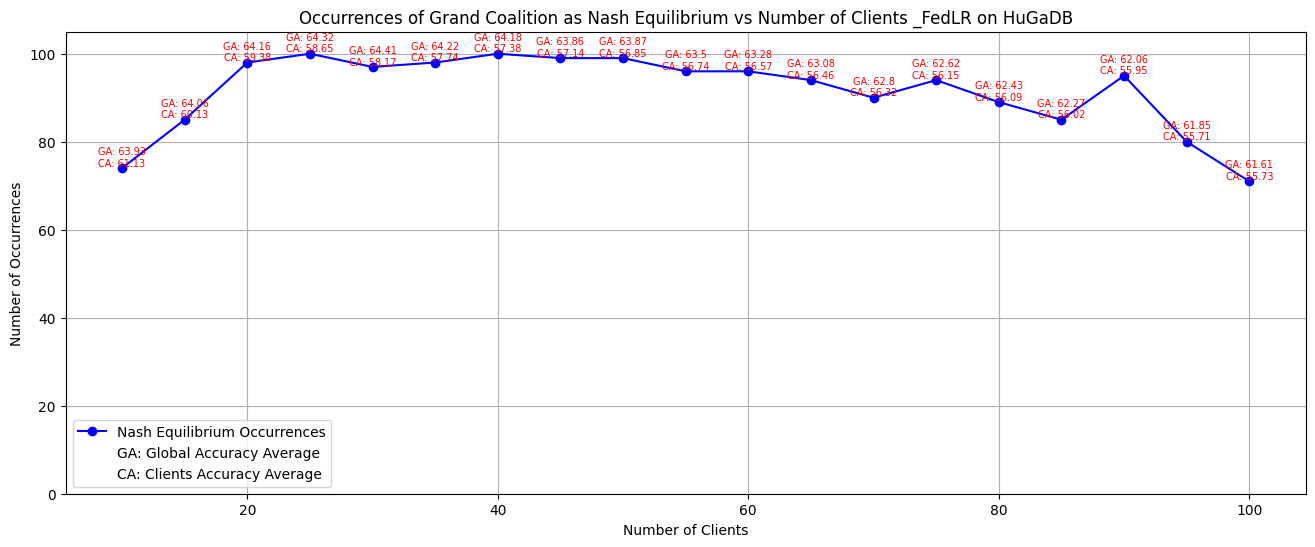

In [9]:
save_dir = "/..."
approach = 'fedlr'
client_range = range(10, 101, 5)


occurrence_counts = []
global_acc_avgs = []
clients_acc_avgs = []

for n_clients in client_range:
    file_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}_nclients_{n_clients}.csv")
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        count = len(df)
        occurrence_counts.append(count)
        

        if 'Global Accuracy' in df.columns:
            global_avg = df['Global Accuracy'].mean()
        else:
            global_avg = np.nan
        global_acc_avgs.append(global_avg)
        

        client_cols = [col for col in df.columns if col.startswith("Client") and "Accuracy" in col]
        if client_cols:
            clients_avg = df[client_cols].mean().mean()
        else:
            clients_avg = np.nan
        clients_acc_avgs.append(clients_avg)
    else:

        occurrence_counts.append(0)
        global_acc_avgs.append(np.nan)
        clients_acc_avgs.append(np.nan)
        print(f"File not found: {file_path}")

plt.figure(figsize=(16, 6))
plt.yticks(np.arange(0, 101, 20))
plt.ylim(0, 105)
line, = plt.plot(list(client_range), occurrence_counts, marker='o', linestyle='-',color= 'blue', label='Nash Equilibrium Occurrences')
plt.title("Occurrences of Grand Coalition as Nash Equilibrium vs Number of Clients _FedLR on HuGaDB")
plt.xlabel("Number of Clients")
plt.ylabel("Number of Occurrences")
plt.grid(True)

for x, occ, g_avg, c_avg in zip(client_range, occurrence_counts, global_acc_avgs, clients_acc_avgs):
    annotation_text = f"GA: {100*g_avg:.4g}\nCA: {100*c_avg:.4g}"
    plt.text(x, occ, annotation_text, color='red', fontsize=7, ha='center', va='bottom')


ga_legend = Line2D([], [], color='red', marker='None', linestyle='None', label='GA: Global Accuracy Average')
ca_legend = Line2D([], [], color='red', marker='None', linestyle='None', label='CA: Clients Accuracy Average')


plt.legend(handles=[line, ga_legend, ca_legend])
plt.show()


### FedFor

In [ ]:
import os, math, random, argparse, ast, copy
from collections import Counter, defaultdict
from itertools import chain, combinations
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import os
import random
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [12]:
from utils.aggregate_functions import FederatedForest
from utils.DecisionTree import DecisionTree
from utils.shapley_value import compute_and_visualize_shapley_values

In [13]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

In [ ]:
n_trials = 50
base_random_seed = 42
max_depths = [10, 100]
approach = 'fedfor'


save_dir = "..."
os.makedirs(save_dir, exist_ok=True)


train_csv_path = ".../metadata/new_runs/train.csv"
df_full_train = pd.read_csv(train_csv_path).dropna(subset=['act']).reset_index(drop=True)


for n_clients in range(10, 101, 5):
    print(f"Running experiments for n_clients = {n_clients}")
    all_details_for_client = [] 
    for max_depth in max_depths:
        nash_counts = Counter()
        details_for_this_param = []
        client_accuracy_details = []


        for trial in range(n_trials):

            rand_component = random.randint(0, 500)
            trial_seed = base_random_seed + trial + int(1000 * max_depth) + 2 * rand_component

            df_trial, _ = train_test_split(
                df_full_train,
                train_size=10000,
                random_state=trial_seed,
                stratify=df_full_train['act']
            )

            df_remaining = df_trial.copy()


            client_partitions = []

            sample_size = 3500 // n_clients
            for client_idx in range(n_clients):

                if len(df_remaining) < sample_size:
                    raise ValueError("err")


                if len(df_remaining) == sample_size:
                    df_client = df_remaining.copy()
                else:
                    df_client, df_remaining = train_test_split(
                        df_remaining,
                        train_size=sample_size,
                        random_state=trial_seed,
                        stratify=df_remaining['act']
                    )
                df_client = df_client.reset_index(drop=True)
                client_partitions.append(df_client)


            client_models = []
            client_global_accuracies = {}

            for client_idx, df_client in enumerate(client_partitions):

                X_client = df_client.drop(columns=['act'])
                y_client = df_client['act']


                client_scaler = StandardScaler()
                X_client_scaled = client_scaler.fit_transform(X_client)


                y_client_encoded = label_encoder.transform(y_client)

               
                model = DecisionTree(max_depth=max_depth, random_state=trial_seed)
                model.fit(X_client_scaled, y_client_encoded)
                client_models.append(model)


                y_pred_global = model.predict(X_test_global_scaled)
                acc_global = accuracy_score(y_test_global, y_pred_global)
                client_global_accuracies[client_idx] = acc_global


            df_results = evaluate_coalitions2(
                client_models=client_models,
                client_global_accuracies=client_global_accuracies,
                n_clients=n_clients,
                aggregator_func=FederatedForest,
                X_test=X_test_global_scaled,
                y_test=y_test_global,
                corrupt_client_indices=[],
                approach=approach
            )
            df_results['Trial'] = trial + 1
            df_results['Max Iter or Depth'] = max_depth


            df_nash = find_nash_equilibria_v2(df_results.reset_index())
            if not df_nash.empty and 'Combination' in df_nash.columns:
                for coalition in df_nash['Combination']:
                    nash_counts[coalition] += 1


            df_nash['Trial'] = trial + 1
            df_nash['Max Iter or Depth'] = max_depth
            details_for_this_param.append(df_nash)


            trial_acc = {
                'Trial': trial + 1,
                'Max Iter or Depth': max_depth,
            }
            for j in range(n_clients):
                trial_acc[f'Client {j+1} Accuracy'] = client_global_accuracies.get(j, np.nan)
            client_accuracy_details.append(trial_acc)


        df_details = pd.concat(details_for_this_param, ignore_index=True)
        df_client_accuracy = pd.DataFrame(client_accuracy_details)
        df_combined = df_details.merge(
            df_client_accuracy,
            on=['Trial', 'Max Iter or Depth'],
            how='left'
        )

        df_combined['n_clients'] = n_clients
        all_details_for_client.append(df_combined)

    final_details_df = pd.concat(all_details_for_client, ignore_index=True)
    details_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}_nclients_{n_clients}.csv")
    final_details_df.to_csv(details_path, index=False)


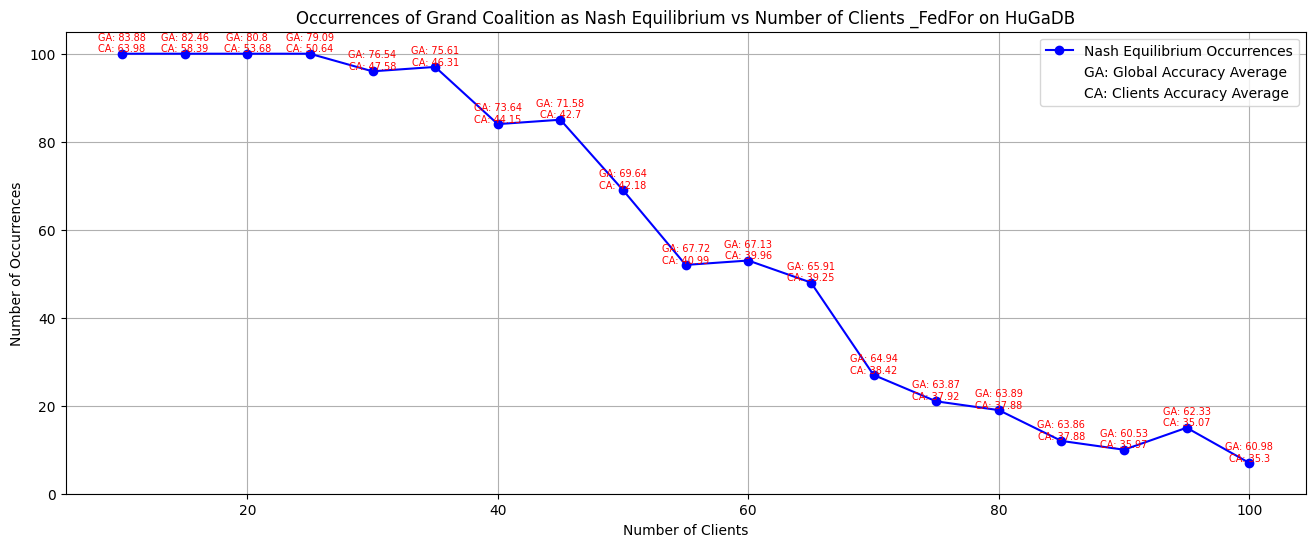

In [ ]:
save_dir = "..."
approach = 'fedlr'
client_range = range(10, 101, 5)


occurrence_counts = []
global_acc_avgs = []
clients_acc_avgs = []

for n_clients in client_range:
    file_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}_nclients_{n_clients}.csv")
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        count = len(df)
        occurrence_counts.append(count)
        

        if 'Global Accuracy' in df.columns:
            global_avg = df['Global Accuracy'].mean()
        else:
            global_avg = np.nan
        global_acc_avgs.append(global_avg)
        

        client_cols = [col for col in df.columns if col.startswith("Client") and "Accuracy" in col]
        if client_cols:
            clients_avg = df[client_cols].mean().mean()
        else:
            clients_avg = np.nan
        clients_acc_avgs.append(clients_avg)
    else:

        occurrence_counts.append(0)
        global_acc_avgs.append(np.nan)
        clients_acc_avgs.append(np.nan)
        print(f"File not found: {file_path}")

plt.figure(figsize=(16, 6))
plt.yticks(np.arange(0, 101, 20))
plt.ylim(0, 105)
line, = plt.plot(list(client_range), occurrence_counts, marker='o', linestyle='-',color= 'blue', label='Nash Equilibrium Occurrences')
plt.title("Occurrences of Grand Coalition as Nash Equilibrium vs Number of Clients _FedLR on HuGaDB")
plt.xlabel("Number of Clients")
plt.ylabel("Number of Occurrences")
plt.grid(True)

for x, occ, g_avg, c_avg in zip(client_range, occurrence_counts, global_acc_avgs, clients_acc_avgs):
    annotation_text = f"GA: {100*g_avg:.4g}\nCA: {100*c_avg:.4g}"
    plt.text(x, occ, annotation_text, color='red', fontsize=7, ha='center', va='bottom')


ga_legend = Line2D([], [], color='red', marker='None', linestyle='None', label='GA: Global Accuracy Average')
ca_legend = Line2D([], [], color='red', marker='None', linestyle='None', label='CA: Clients Accuracy Average')


plt.legend(handles=[line, ga_legend, ca_legend])
plt.show()


#### sample_size = 7000 // n_clients and test size is : Subsampled test set shape: (1500, 38)

In [ ]:
n_trials = 50
base_random_seed = 42
max_depths = [10, 100]
approach = 'fedfor'


save_dir = "..."
os.makedirs(save_dir, exist_ok=True)


train_csv_path = ".../data/metadata/new_runs/train.csv"
df_full_train = pd.read_csv(train_csv_path).dropna(subset=['act']).reset_index(drop=True)


for n_clients in range(10, 101, 5):
    print(f"Running experiments for n_clients = {n_clients}")
    all_details_for_client = [] 
    for max_depth in max_depths:
        nash_counts = Counter()
        details_for_this_param = []
        client_accuracy_details = []


        for trial in range(n_trials):

            rand_component = random.randint(0, 500)
            trial_seed = base_random_seed + trial + int(1000 * max_depth) + 2 * rand_component

            df_trial, _ = train_test_split(
                df_full_train,
                train_size=10000,
                random_state=trial_seed,
                stratify=df_full_train['act']
            )

            df_remaining = df_trial.copy()


            client_partitions = []

            sample_size = 7000 // n_clients
            for client_idx in range(n_clients):

                if len(df_remaining) < sample_size:
                    raise ValueError("err")


                if len(df_remaining) == sample_size:
                    df_client = df_remaining.copy()
                else:
                    df_client, df_remaining = train_test_split(
                        df_remaining,
                        train_size=sample_size,
                        random_state=trial_seed,
                        stratify=df_remaining['act']
                    )
                df_client = df_client.reset_index(drop=True)
                client_partitions.append(df_client)


            client_models = []
            client_global_accuracies = {}

            for client_idx, df_client in enumerate(client_partitions):

                X_client = df_client.drop(columns=['act'])
                y_client = df_client['act']


                client_scaler = StandardScaler()
                X_client_scaled = client_scaler.fit_transform(X_client)


                y_client_encoded = label_encoder.transform(y_client)

               
                model = DecisionTree(max_depth=max_depth, random_state=trial_seed)
                model.fit(X_client_scaled, y_client_encoded)
                client_models.append(model)


                y_pred_global = model.predict(X_test_global_scaled)
                acc_global = accuracy_score(y_test_global, y_pred_global)
                client_global_accuracies[client_idx] = acc_global


            df_results = evaluate_coalitions2(
                client_models=client_models,
                client_global_accuracies=client_global_accuracies,
                n_clients=n_clients,
                aggregator_func=FederatedForest,
                X_test=X_test_global_scaled,
                y_test=y_test_global,
                corrupt_client_indices=[],
                approach=approach
            )
            df_results['Trial'] = trial + 1
            df_results['Max Iter or Depth'] = max_depth


            df_nash = find_nash_equilibria_v2(df_results.reset_index())
            if not df_nash.empty and 'Combination' in df_nash.columns:
                for coalition in df_nash['Combination']:
                    nash_counts[coalition] += 1


            df_nash['Trial'] = trial + 1
            df_nash['Max Iter or Depth'] = max_depth
            details_for_this_param.append(df_nash)


            trial_acc = {
                'Trial': trial + 1,
                'Max Iter or Depth': max_depth,
            }
            for j in range(n_clients):
                trial_acc[f'Client {j+1} Accuracy'] = client_global_accuracies.get(j, np.nan)
            client_accuracy_details.append(trial_acc)


        df_details = pd.concat(details_for_this_param, ignore_index=True)
        df_client_accuracy = pd.DataFrame(client_accuracy_details)
        df_combined = df_details.merge(
            df_client_accuracy,
            on=['Trial', 'Max Iter or Depth'],
            how='left'
        )

        df_combined['n_clients'] = n_clients
        all_details_for_client.append(df_combined)

    final_details_df = pd.concat(all_details_for_client, ignore_index=True)
    details_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}_nclients_{n_clients}.csv")
    final_details_df.to_csv(details_path, index=False)


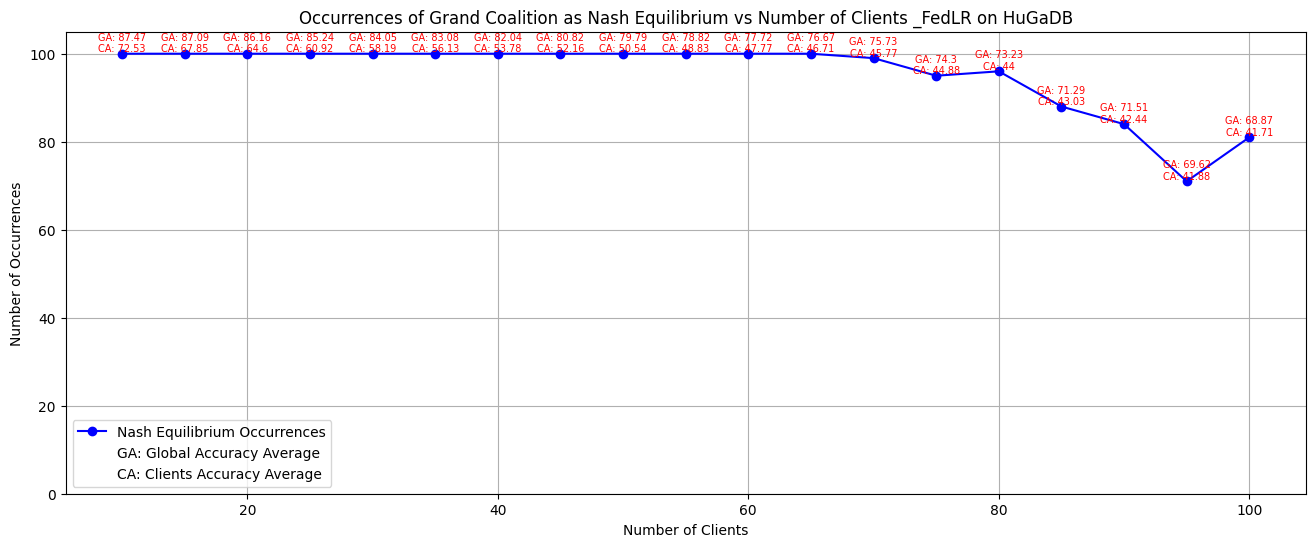

In [ ]:
save_dir = "..."
approach = 'fedfor'
client_range = range(10, 101, 5)


occurrence_counts = []
global_acc_avgs = []
clients_acc_avgs = []

for n_clients in client_range:
    file_path = os.path.join(save_dir, f"Nash_Equilibrium_Details_{approach}_nclients_{n_clients}.csv")
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        count = len(df)
        occurrence_counts.append(count)
        

        if 'Global Accuracy' in df.columns:
            global_avg = df['Global Accuracy'].mean()
        else:
            global_avg = np.nan
        global_acc_avgs.append(global_avg)
        

        client_cols = [col for col in df.columns if col.startswith("Client") and "Accuracy" in col]
        if client_cols:
            clients_avg = df[client_cols].mean().mean()
        else:
            clients_avg = np.nan
        clients_acc_avgs.append(clients_avg)
    else:

        occurrence_counts.append(0)
        global_acc_avgs.append(np.nan)
        clients_acc_avgs.append(np.nan)
        print(f"File not found: {file_path}")

plt.figure(figsize=(16, 6))
plt.yticks(np.arange(0, 101, 20))
plt.ylim(0, 105)
line, = plt.plot(list(client_range), occurrence_counts, marker='o', linestyle='-',color= 'blue', label='Nash Equilibrium Occurrences')
plt.title("Occurrences of Grand Coalition as Nash Equilibrium vs Number of Clients _FedLR on HuGaDB")
plt.xlabel("Number of Clients")
plt.ylabel("Number of Occurrences")
plt.grid(True)

for x, occ, g_avg, c_avg in zip(client_range, occurrence_counts, global_acc_avgs, clients_acc_avgs):
    annotation_text = f"GA: {100*g_avg:.4g}\nCA: {100*c_avg:.4g}"
    plt.text(x, occ, annotation_text, color='red', fontsize=7, ha='center', va='bottom')


ga_legend = Line2D([], [], color='red', marker='None', linestyle='None', label='GA: Global Accuracy Average')
ca_legend = Line2D([], [], color='red', marker='None', linestyle='None', label='CA: Clients Accuracy Average')


plt.legend(handles=[line, ga_legend, ca_legend])
plt.show()
